Step 1: Loading metadata and preparing file paths...
Successfully located files for 12 subjects
Step 2: Extracting structural MRI features from Freesurfer stats...
Processing structural features for sub-003S6915
Processing structural features for sub-032S6602
Processing structural features for sub-037S1078
Processing structural features for sub-002S6066
Processing structural features for sub-168S6065
Processing structural features for sub-003S6256
Processing structural features for sub-041S4200
Processing structural features for sub-003S6264
Processing structural features for sub-003S6833
Processing structural features for sub-032S6855
Processing structural features for sub-035S6380
Processing structural features for sub-168S6821
Extracted 68 structural features from 12 subjects
Step 3: Extracting functional connectivity features...


[get_dataset_dir] Dataset found in C:\Users\Alireza217\nilearn_data\aal_SPM12

Using Nilearn's AAL atlas: C:\Users\Alireza217\nilearn_data\aal_SPM12\aal\atlas\AAL.nii
Processing functional connectivity for sub-003S6915
Processing functional connectivity for sub-032S6602
Processing functional connectivity for sub-037S1078
Processing functional connectivity for sub-002S6066
Processing functional connectivity for sub-168S6065
Processing functional connectivity for sub-003S6256
Processing functional connectivity for sub-041S4200
Processing functional connectivity for sub-003S6264
Processing functional connectivity for sub-003S6833
Processing functional connectivity for sub-032S6855
Processing functional connectivity for sub-035S6380
Processing functional connectivity for sub-168S6821
Extracted 6669 functional connectivity features from 12 subjects
Step 4: Integrating and preprocessing data...
Reduced functional features from 6670 to 10 components
Data integration complete:
Demographic features: (12, 2)
Structural features: (12, 68)
Functional features: (12, 10)
Combi

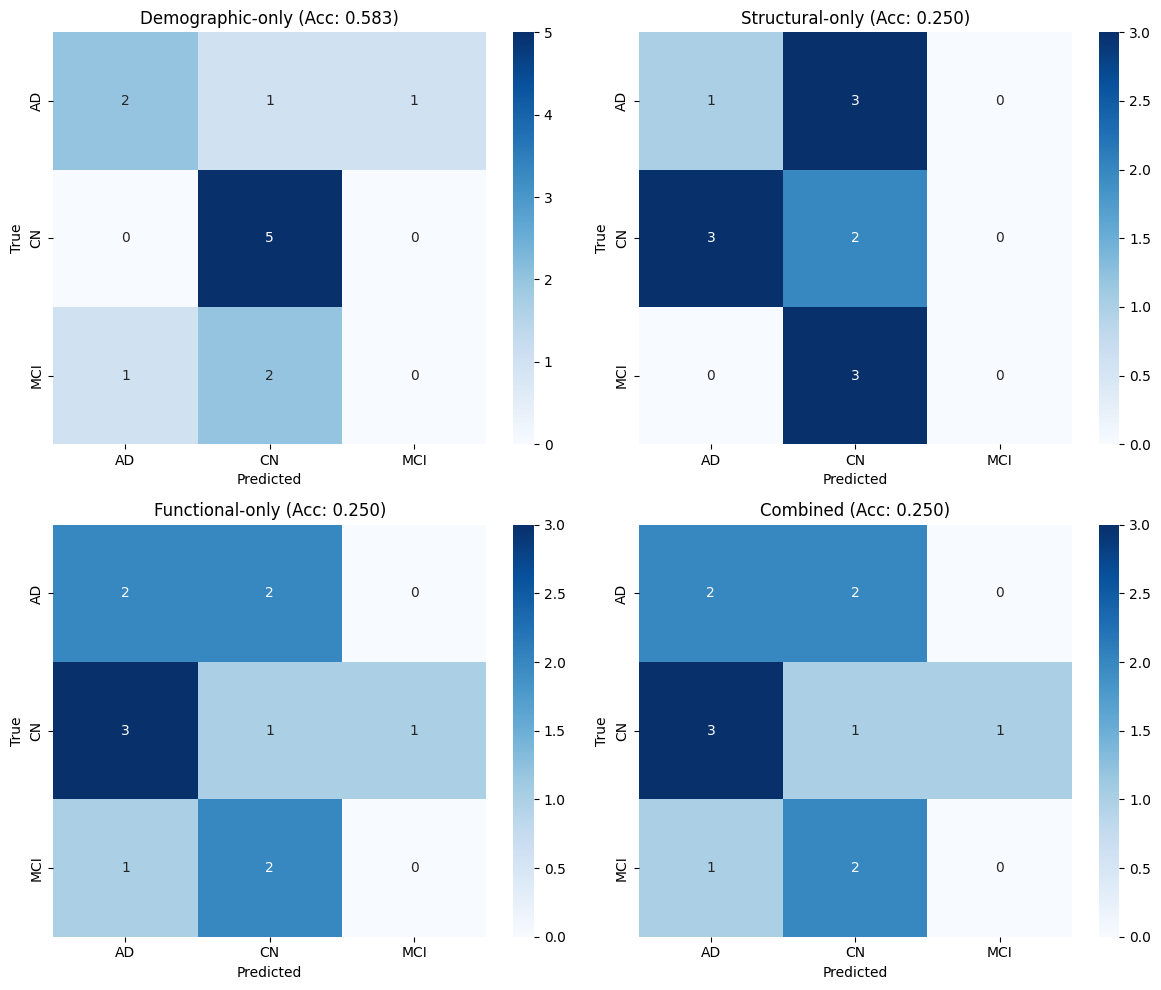

Step 6: Generating model explanations with SHAP...


C:\Users\Alireza217\AppData\Local\Temp\ipykernel_25812\3400532197.py:433: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_combined, feature_names=all_feature_names,
C:\Users\Alireza217\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
C:\Users\Alireza217\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  su

SHAP plots saved to output directory
Step 7: Saving results...
All results saved successfully!
Script execution complete.


<Figure size 1400x1000 with 0 Axes>

In [17]:
# -*- coding: utf-8 -*-
"""
Pilot Study: Multimodal (sMRI+fMRI) Classification of Alzheimer's Disease
Author: Alireza Emad
Description: This script implements an end-to-end pipeline for classifying CN, MCI, and AD subjects
using structural MRI (Freesurfer), functional MRI (connectivity), and demographic features.
Dataset: 12 subjects from ADNI, preprocessed via Brainlife.io.
"""

# Import necessary libraries
import os
import glob
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for machine learning
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# SHAP for explainable AI
import shap

# Set random seed for reproducibility
np.random.seed(42)

# =============================================================================
# CONFIGURATION - PLEASE UPDATE THESE PATHS FOR YOUR SYSTEM
# =============================================================================

# Root directory where all subject folders are located
ROOT_DIR = r"Dataset directory"

# Path to your Excel file with subject metadata
METADATA_PATH = r"Metadata Excel file"

# Path to the AAL atlas (it will be downloaded if not found)
ATLAS_PATH = r"Brain atlas directory"

# Output directory for results
OUTPUT_DIR = r"Output directory"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# =============================================================================
# DATA LOADING AND PREPARATION
# =============================================================================

print("Step 1: Loading metadata and preparing file paths...")

# Load subject metadata
df_meta = pd.read_excel(METADATA_PATH)

# Get all subject folders in the root directory
all_folders = [f for f in os.listdir(ROOT_DIR) if os.path.isdir(os.path.join(ROOT_DIR, f))]

# Initialize lists to store file paths
bold_paths = []
stats_dirs = []
subject_ids_clean = []
demographic_data = []

# Loop through each subject in the metadata and find matching folders
for _, row in df_meta.iterrows():
    subject_id = row['subject_id']
    diagnosis = row['CLASS']
    sex = row['SEX']
    age = row['AGE']
    
    # Find folder that starts with this subject ID
    matching_folders = [f for f in all_folders if f.startswith(subject_id)]
    
    if not matching_folders:
        print(f"Warning: Could not find folder for subject {subject_id}")
        continue
        
    subject_folder = matching_folders[0]
    subject_path = os.path.join(ROOT_DIR, subject_folder)
    
    # Find the preprocessed BOLD file (pattern matches the Brainlife.io structure)
    bold_pattern = os.path.join(subject_path, "dt-neuro-func-task.tag-rest.tag-preprocessed.id-*", "bold.nii.gz")
    bold_matches = glob.glob(bold_pattern)
    
    # Find the Freesurfer stats directory
    stats_pattern = os.path.join(subject_path, "dt-neuro-freesurfer.id-*", "output", "stats")
    stats_matches = glob.glob(stats_pattern)
    
    # If both files are found, add them to our lists
    if bold_matches and stats_matches:
        bold_paths.append(bold_matches[0])
        stats_dirs.append(stats_matches[0])
        subject_ids_clean.append(subject_id)
        
        # Store demographic data
        demographic_data.append({
            'subject_id': subject_id,
            'sex': sex,
            'age': age,
            'diagnosis': diagnosis
        })
    else:
        print(f"Warning: Could not find files for subject {subject_id} in folder {subject_folder}")

# Create demographic DataFrame
df_demographic = pd.DataFrame(demographic_data)
df_demographic.set_index('subject_id', inplace=True)

print(f"Successfully located files for {len(subject_ids_clean)} subjects")

# =============================================================================
# FEATURE EXTRACTION: STRUCTURAL MRI (FREESURFER)
# =============================================================================

print("Step 2: Extracting structural MRI features from Freesurfer stats...")

def parse_freesurfer_stats(stats_dir):
    """
    Parses Freesurfer statistics files to extract cortical thickness
    and subcortical volume measurements.
    
    Parameters:
    stats_dir (str): Path to the Freesurfer stats directory
    
    Returns:
    dict: Dictionary of structural features
    """
    features = {}
    
    # Parse aseg.stats for subcortical volumes
    aseg_file = os.path.join(stats_dir, "aseg.stats")
    if os.path.exists(aseg_file):
        with open(aseg_file, 'r') as f:
            for line in f:
                if line.strip() and not line.startswith('#'):
                    parts = line.split()
                    if len(parts) >= 4 and parts[3].isdigit():
                        feature_name = parts[4]
                        volume = float(parts[3])
                        features[feature_name] = volume
    
    # Parse cortical thickness statistics
    for hemisphere in ['lh', 'rh']:
        aparc_file = os.path.join(stats_dir, f"{hemisphere}.aparc.stats")
        if os.path.exists(aparc_file):
            with open(aparc_file, 'r') as f:
                for line in f:
                    if line.strip() and not line.startswith('#'):
                        parts = line.split()
                        if len(parts) >= 4 and parts[3].replace('.', '').isdigit():
                            feature_name = f"{hemisphere}_{parts[0]}"
                            thickness = float(parts[3])
                            features[feature_name] = thickness
    
    return features

# Extract structural features for all subjects
structural_features = []
for i, stats_dir in enumerate(stats_dirs):
    subject_id = subject_ids_clean[i]
    print(f"Processing structural features for {subject_id}")
    
    try:
        features = parse_freesurfer_stats(stats_dir)
        features['subject_id'] = subject_id
        structural_features.append(features)
    except Exception as e:
        print(f"Error processing {subject_id}: {str(e)}")

# Convert to DataFrame
df_structural = pd.DataFrame(structural_features)
df_structural.set_index('subject_id', inplace=True)

# Handle missing values if any
imputer = SimpleImputer(strategy='mean')
structural_imputed = imputer.fit_transform(df_structural)
df_structural = pd.DataFrame(structural_imputed, 
                            columns=df_structural.columns, 
                            index=df_structural.index)

print(f"Extracted {df_structural.shape[1]} structural features from {df_structural.shape[0]} subjects")

# =============================================================================
# FEATURE EXTRACTION: FUNCTIONAL MRI (CONNECTIVITY)
# =============================================================================

print("Step 3: Extracting functional connectivity features...")

# Load or download AAL atlas
if not os.path.exists(ATLAS_PATH):
    print("Downloading AAL atlas...")
    os.makedirs(os.path.dirname(ATLAS_PATH), exist_ok=True)
    # Use Nilearn's built-in atlas
    aal = datasets.fetch_atlas_aal()
    atlas_path = aal.maps
    print(f"Using Nilearn's AAL atlas: {atlas_path}")
else:
    atlas_path = ATLAS_PATH
    print(f"Using existing AAL atlas: {atlas_path}")

# Load the atlas image
atlas_img = nib.load(atlas_path)

# Initialize connectivity measure
connectivity_measure = ConnectivityMeasure(
    kind='correlation', 
    vectorize=True,  # Return flattened upper triangle
    discard_diagonal=True
)

# Initialize masker
masker = NiftiLabelsMasker(
    labels_img=atlas_img,
    standardize=True,
    memory='nilearn_cache',
    verbose=0
)

# Extract connectivity features for each subject
functional_features = []

for i, bold_path in enumerate(bold_paths):
    subject_id = subject_ids_clean[i]
    print(f"Processing functional connectivity for {subject_id}")
    
    try:
        # Load the preprocessed BOLD data
        bold_img = nib.load(bold_path)
        
        # Extract time series from regions
        time_series = masker.fit_transform(bold_img)
        
        # Calculate connectivity matrix
        connectivity_matrix = connectivity_measure.fit_transform([time_series])[0]
        
        # Create feature dictionary
        features = {f'conn_{i}': val for i, val in enumerate(connectivity_matrix)}
        features['subject_id'] = subject_id
        
        functional_features.append(features)
        
    except Exception as e:
        print(f"Error processing {subject_id}: {str(e)}")

# Convert to DataFrame
df_functional = pd.DataFrame(functional_features)
df_functional.set_index('subject_id', inplace=True)

print(f"Extracted {df_functional.shape[1]-1} functional connectivity features from {df_functional.shape[0]} subjects")

# =============================================================================
# DATA INTEGRATION AND PREPROCESSING
# =============================================================================

print("Step 4: Integrating and preprocessing data...")

# Prepare demographic features
# One-hot encode sex and standardize age
sex_encoder = OneHotEncoder(sparse_output=False, drop='first')
sex_encoded = sex_encoder.fit_transform(df_demographic[['sex']])
sex_feature_names = sex_encoder.get_feature_names_out(['sex'])

# Standardize age
age_scaler = StandardScaler()
age_scaled = age_scaler.fit_transform(df_demographic[['age']])

# Create demographic feature matrix
X_demo = np.concatenate([sex_encoded, age_scaled], axis=1)
demo_feature_names = list(sex_feature_names) + ['age']

# Prepare imaging feature matrices
X_struct = df_structural.values
X_func = df_functional.values

# Standardize imaging features
scaler_struct = StandardScaler()
X_struct_scaled = scaler_struct.fit_transform(X_struct)

scaler_func = StandardScaler()
X_func_scaled = scaler_func.fit_transform(X_func)

# Apply PCA to functional data to reduce dimensionality
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_func_pca = pca.fit_transform(X_func_scaled)

print(f"Reduced functional features from {X_func_scaled.shape[1]} to {X_func_pca.shape[1]} components")

# Combine all features
X_combined = np.concatenate([X_demo, X_struct_scaled, X_func_pca], axis=1)

# Prepare labels
y = df_demographic['diagnosis'].values

# Encode labels (CN->0, MCI->1, AD->2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Data integration complete:")
print(f"Demographic features: {X_demo.shape}")
print(f"Structural features: {X_struct_scaled.shape}")
print(f"Functional features: {X_func_pca.shape}")
print(f"Combined features: {X_combined.shape}")
print(f"Labels: {y_encoded.shape}")

# =============================================================================
# MODEL TRAINING AND EVALUATION
# =============================================================================

print("Step 5: Training and evaluating models...")

# Initialize models
model_demo = LogisticRegression(max_iter=1000, random_state=42)
model_struct = LogisticRegression(max_iter=1000, random_state=42)
model_func = LogisticRegression(max_iter=1000, random_state=42)
model_combined = LogisticRegression(max_iter=1000, random_state=42)

# Create feature sets for different model combinations
X_demo_only = X_demo
X_struct_only = X_struct_scaled
X_func_only = X_func_pca

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

# Store predictions
y_true, y_pred_demo, y_pred_struct, y_pred_func, y_pred_combined = [], [], [], [], []

for train_idx, test_idx in loo.split(X_combined):
    # Get train/test data for all modalities
    X_demo_train, X_demo_test = X_demo_only[train_idx], X_demo_only[test_idx]
    X_struct_train, X_struct_test = X_struct_only[train_idx], X_struct_only[test_idx]
    X_func_train, X_func_test = X_func_only[train_idx], X_func_only[test_idx]
    X_combined_train, X_combined_test = X_combined[train_idx], X_combined[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
    
    # Train and predict with demographic model
    model_demo.fit(X_demo_train, y_train)
    pred_demo = model_demo.predict(X_demo_test)
    
    # Train and predict with structural model
    model_struct.fit(X_struct_train, y_train)
    pred_struct = model_struct.predict(X_struct_test)
    
    # Train and predict with functional model
    model_func.fit(X_func_train, y_train)
    pred_func = model_func.predict(X_func_test)
    
    # Train and predict with combined model
    model_combined.fit(X_combined_train, y_train)
    pred_combined = model_combined.predict(X_combined_test)
    
    # Store results
    y_true.append(y_test[0])
    y_pred_demo.append(pred_demo[0])
    y_pred_struct.append(pred_struct[0])
    y_pred_func.append(pred_func[0])
    y_pred_combined.append(pred_combined[0])

# Calculate accuracies
acc_demo = accuracy_score(y_true, y_pred_demo)
acc_struct = accuracy_score(y_true, y_pred_struct)
acc_func = accuracy_score(y_true, y_pred_func)
acc_combined = accuracy_score(y_true, y_pred_combined)

print("\nClassification Results:")
print(f"Demographic-only Accuracy: {acc_demo:.3f}")
print(f"Structural-only Accuracy: {acc_struct:.3f}")
print(f"Functional-only Accuracy: {acc_func:.3f}")
print(f"Combined Accuracy: {acc_combined:.3f}")

# Generate confusion matrices
cm_demo = confusion_matrix(y_true, y_pred_demo)
cm_struct = confusion_matrix(y_true, y_pred_struct)
cm_func = confusion_matrix(y_true, y_pred_func)
cm_combined = confusion_matrix(y_true, y_pred_combined)

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.heatmap(cm_demo, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0, 0].set_title(f'Demographic-only (Acc: {acc_demo:.3f})')

sns.heatmap(cm_struct, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0, 1].set_title(f'Structural-only (Acc: {acc_struct:.3f})')

sns.heatmap(cm_func, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1, 0].set_title(f'Functional-only (Acc: {acc_func:.3f})')

sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1, 1].set_title(f'Combined (Acc: {acc_combined:.3f})')

for ax in axes.flat:
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# MODEL INTERPRETATION WITH SHAP
# =============================================================================

print("Step 6: Generating model explanations with SHAP...")

# Train a final model on all data for interpretation
final_model = LogisticRegression(max_iter=1000, random_state=42)
final_model.fit(X_combined, y_encoded)

# Create SHAP explainer
explainer = shap.LinearExplainer(final_model, X_combined)
shap_values = explainer.shap_values(X_combined)

# Get feature names
demo_feature_names = list(demo_feature_names)
struct_feature_names = df_structural.columns.tolist()
func_feature_names = [f'func_pc_{i}' for i in range(X_func_pca.shape[1])]
all_feature_names = demo_feature_names + struct_feature_names + func_feature_names

# Plot summary plot
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_combined, feature_names=all_feature_names, 
                  class_names=le.classes_, show=False)
plt.savefig(os.path.join(OUTPUT_DIR, 'shap_summary.png'), dpi=300, bbox_inches='tight')
plt.close()

# Plot bar plot for mean |SHAP values|
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_combined, feature_names=all_feature_names, 
                  plot_type="bar", class_names=le.classes_, show=False)
plt.savefig(os.path.join(OUTPUT_DIR, 'shap_bar.png'), dpi=300, bbox_inches='tight')
plt.close()

print("SHAP plots saved to output directory")

# =============================================================================
# SAVE RESULTS
# =============================================================================

print("Step 7: Saving results...")

# Save accuracies to a file
with open(os.path.join(OUTPUT_DIR, 'results.txt'), 'w') as f:
    f.write("Pilot Study Results\n")
    f.write("===================\n\n")
    f.write(f"Subjects: {len(subject_ids_clean)}\n")
    f.write(f"Demographic Features: {X_demo.shape[1]}\n")
    f.write(f"Structural Features: {X_struct_scaled.shape[1]}\n")
    f.write(f"Functional Features (after PCA): {X_func_pca.shape[1]}\n")
    f.write(f"Demographic-only Accuracy: {acc_demo:.3f}\n")
    f.write(f"Structural-only Accuracy: {acc_struct:.3f}\n")
    f.write(f"Functional-only Accuracy: {acc_func:.3f}\n")
    f.write(f"Combined Accuracy: {acc_combined:.3f}\n\n")
    
    f.write("Classification Report (Combined Model):\n")
    f.write(classification_report(y_true, y_pred_combined, 
                                 target_names=le.classes_))

# Save feature names for reference
pd.Series(all_feature_names).to_csv(os.path.join(OUTPUT_DIR, 'feature_names.csv'), index=False)

# Save the demographic data for reference
df_demographic.to_csv(os.path.join(OUTPUT_DIR, 'demographic_data.csv'))

print("All results saved successfully!")
print("Script execution complete.")